In [1]:
# SETUP AND IMPORTS
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import warnings
import sys
import os

# --- PyTorch and Sklearn Imports --
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset, SubsetRandomSampler
from sklearn.model_selection import KFold
from sklearn.metrics import average_precision_score
from tqdm.notebook import tqdm

# --- TensorFlow for Data Loading ONLY --
import tensorflow as tf

# --- CRITICAL FIX v2: Isolate TensorFlow to CPU without hiding the GPU from PyTorch ---
try:
    physical_devices = tf.config.list_physical_devices()
    cpus = [d for d in physical_devices if d.device_type == 'CPU']
    tf.config.set_visible_devices(cpus)
    print("✅ TensorFlow successfully configured to use CPU only.")
    
    # --- VERIFICATION STEP ---
    if not tf.config.list_physical_devices('GPU'):
        print("   - Confirmed: TensorFlow does not see the GPU.")
    else:
        print("   - ⚠️ WARNING: TensorFlow can still see the GPU. Conflicts may occur.")

    if torch.cuda.is_available():
        print("✅ PyTorch can see and use the GPU.")
        print(f"   - GPU Device Name: {torch.cuda.get_device_name(0)}")
    else:
        print("   - ❌ CRITICAL WARNING: PyTorch cannot see the GPU. Training will be on CPU.")

except Exception as e:
    print(f"An error occurred during device configuration: {e}")


warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Define data directory
DATA_DIR = Path("/kaggle/input/modified-next-day-wildfire-spread/ndws_western_dataset")
print(f"📁 Data directory: {DATA_DIR}")
print(f"📂 Directory exists: {DATA_DIR.exists()}")

# --- CORRECTED TFRecord PARSING FUNCTION --
def parse_tfrecord_flexible(example):
    """
    Parse TFRecord with the CORRECT feature description.
    """
    feature_description = {}
    
    expected_features = [
        'elevation', 'NDVI', 'erc', 'pr', 'pdsi', 'population',
        'impervious', 'water', 'tmp_day', 'tmp_75', 'wind_avg', 'wind_75',
        'wdir_wind', 'wdir_gust', 'gust_med', 'avg_sph', 'bi', 'chili',
        'fuel1', 'fuel2', 'fuel3', 'viirs_PrevFireMask', 'viirs_FireMask'
    ]
    
    for feat in expected_features:
        feature_description[feat] = tf.io.FixedLenFeature([64, 64], tf.float32)
    
    parsed_features = tf.io.parse_single_example(example, feature_description)
    return parsed_features

print("\n✅ Setup complete!")

2025-10-10 09:56:20.949606: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760090181.121568      77 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760090181.179081      77 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


✅ TensorFlow successfully configured to use CPU only.
   - ⚠️ WARNING: TensorFlow can still see the GPU. Conflicts may occur.
✅ PyTorch can see and use the GPU.
   - GPU Device Name: Tesla P100-PCIE-16GB
📁 Data directory: /kaggle/input/modified-next-day-wildfire-spread/ndws_western_dataset
📂 Directory exists: True

✅ Setup complete!


In [2]:
# VISUALIZATION FUNCTIONS (PYTORCH VERSION)
def visualize_fire_predictions_pytorch(model, X_test, y_test, num_samples=4):
    """Visualize fire prediction results from a PyTorch model"""
    if len(X_test) == 0:
        print("❌ No test samples available for visualization")
        return

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    X_test_subset = X_test[:num_samples]
    y_test_subset = y_test[:num_samples]
    
    with torch.no_grad():
        # Transpose from (N, H, W, C) to (N, C, H, W) for PyTorch
        X_test_tensor = torch.from_numpy(np.transpose(X_test_subset, (0, 3, 1, 2))).float().to(device)
        predictions_tensor = model(X_test_tensor)
        # Transpose back to (N, H, W, C) for visualization with Matplotlib
        predictions = np.transpose(predictions_tensor.cpu().numpy(), (0, 2, 3, 1))

    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)

    for i in range(num_samples):
        input_fire = X_test_subset[i, :, :, 0]
        true_fire = y_test_subset[i, :, :, 0]
        pred_fire = predictions[i, :, :, 0]

        axes[i, 0].imshow(input_fire, cmap='Reds', vmin=0, vmax=1)
        axes[i, 0].set_title(f'Sample {i+1}: Input Fire (t)')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(true_fire, cmap='Reds', vmin=0, vmax=1)
        # --- CORRECTED LABEL ---
        axes[i, 1].set_title(f'True Fire (t+1)')
        axes[i, 1].axis('off')

        axes[i, 2].imshow(pred_fire, cmap='Reds', vmin=0, vmax=1)
        # --- CORRECTED LABEL ---
        axes[i, 2].set_title(f'Predicted Fire (t+1)')
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

    # Print statistics
    print(f"\n📊 PREDICTION STATISTICS:")
    print(f"🔥 True fire pixels in displayed samples: {np.sum(y_test_subset > 0.1)}")
    print(f"🎯 Predicted fire pixels (threshold > 0.5): {np.sum(predictions > 0.5)}")
    print(f"📈 Average prediction confidence: {np.mean(predictions):.4f}")

print("✅ PyTorch visualization function defined with corrected t+1 labels!")

✅ PyTorch visualization function defined with corrected t+1 labels!


# 🔥 SPATIAL FIRE SPREAD PREDICTION WITH U-NET ARCHITECTURE

**CRITICAL FIX**: This section implements proper spatial fire spread prediction using:
- ✅ **Raw spatial features** (64x64 grids) - NOT statistical summaries
- ✅ **All 23 environmental features** as spatial inputs
- ✅ **U-Net architecture** for pixel-level fire spread prediction
- ✅ **Temporal prediction**: PrevFireMask(t) → FireMask(t+1)
- ✅ **Research-based approach** following wildfire prediction literature

**Key Point**: The engineered features above are for EDA/visualization only. All prediction uses RAW SPATIAL DATA.

In [3]:
# --- FINAL DATA PROCESSOR: COMBINING TIME-SERIES AND CURRENT DAY DATA ---

class CombinedFireDataProcessor:
    """
    Processes data to give the model the best of both worlds:
    - Historical environmental context (from the past)
    - Current day fire and environmental state
    """
    def __init__(self, data_dir=DATA_DIR, num_timesteps=4):
        self.data_dir = data_dir
        self.num_timesteps = num_timesteps # Past days of environmental data
        self.environmental_features = [
            'elevation', 'NDVI', 'erc', 'pr', 'pdsi', 'population',
            'impervious', 'water', 'tmp_day', 'tmp_75', 'wind_avg', 'wind_75',
            'wdir_wind', 'wdir_gust', 'gust_med', 'avg_sph', 'bi', 'chili',
            'fuel1', 'fuel2', 'fuel3'
        ]

    def load_raw_spatial_data(self, max_sequences=None):
        """
        Load and create the ultimate time-series sequences.
        Input X: viirs_PrevFireMask(t) + Env Features(t-4 to t-1) + Env Features(t)
        Target Y: viirs_FireMask(t+1)
        """
        print("🔥 Loading RAW SPATIAL DATA for COMBINED (Time-Series + Current Day) prediction...")
        
        tfrecord_files = list(self.data_dir.glob("*.tfrecord"))
        if not tfrecord_files:
            print("❌ No TFRecord files found!")
            return None, None
        print(f"📁 Found {len(tfrecord_files)} TFRecord files")

        all_samples_flat = []
        
        # --- CORRECTED MEMORY-EFFICIENT LOADING LOGIC ---
        samples_to_load = float('inf') # Load all if max_sequences is None
        if max_sequences:
            sequence_len = self.num_timesteps + 2
            samples_to_load = max_sequences + sequence_len - 1
            print(f" M Optimizing data loading for max_sequences={max_sequences}. Need to load up to {samples_to_load} samples.")

        # Load daily snapshots, stopping only when enough have been collected
        for file_path in tfrecord_files:
            if len(all_samples_flat) >= samples_to_load:
                break # Stop reading files if we have enough samples

            dataset = tf.data.TFRecordDataset(str(file_path))
            for raw_record in dataset:
                if len(all_samples_flat) >= samples_to_load:
                    break # Stop reading records within a file if we have enough
                try:
                    parsed_sample = parse_tfrecord_flexible(raw_record)
                    sample_data = {name: tensor.numpy() for name, tensor in parsed_sample.items()}
                    if 'viirs_PrevFireMask' in sample_data and 'viirs_FireMask' in sample_data:
                        all_samples_flat.append(sample_data)
                except Exception as e:
                    print(f"❗️ FAILED TO PROCESS A RECORD in {file_path.name}. Error: {e}")
        
        print(f"  ...Loaded {len(all_samples_flat)} total individual samples.")

        if not all_samples_flat:
             print("❌ No valid samples were loaded.")
             return None, None

        # --- COMBINED SLIDING WINDOW LOGIC (Unchanged) ---
        spatial_inputs, spatial_targets = [], []
        sequence_len = self.num_timesteps + 2
        
        for i in range(len(all_samples_flat) - sequence_len + 1):
            if max_sequences and len(spatial_inputs) >= max_sequences:
                break

            past_environmental_sequence = all_samples_flat[i : i + self.num_timesteps]
            current_day_sample = all_samples_flat[i + self.num_timesteps]
            next_day_sample = all_samples_flat[i + self.num_timesteps + 1]

            input_features = []
            input_features.append(current_day_sample['viirs_PrevFireMask'].reshape(64, 64, 1))
            for past_sample in past_environmental_sequence:
                for feature_name in self.environmental_features:
                    if feature_name in past_sample:
                        input_features.append(past_sample[feature_name].reshape(64, 64, 1))
            for feature_name in self.environmental_features:
                 if feature_name in current_day_sample:
                    input_features.append(current_day_sample[feature_name].reshape(64, 64, 1))

            target_mask = next_day_sample['viirs_FireMask'].reshape(64, 64, 1)

            if len(input_features) > 1:
                spatial_inputs.append(np.concatenate(input_features, axis=2))
                spatial_targets.append(target_mask)

        if not spatial_inputs:
            print("❌ Could not create any sequences with the combined logic!")
            return None, None
            
        X_spatial = np.array(spatial_inputs, dtype=np.float32)
        y_spatial = np.array(spatial_targets, dtype=np.float32)

        print(f"\n✅ COMBINED DATA LOADING COMPLETE")
        print(f"📊 Spatial Input Shape: {X_spatial.shape}")
        print(f"📊 Spatial Target Shape: {y_spatial.shape}")
        return X_spatial, y_spatial

In [4]:
# --- NEW: CUSTOM PYTORCH DATASET FOR EFFICIENT MEMORY USAGE ---
import random
from torch.utils.data import Dataset, SubsetRandomSampler

class WildfireDataset(Dataset):
    """
    PyTorch Dataset for loading wildfire sequences "just-in-time" from TFRecords.
    This avoids loading the entire dataset into memory.
    """
    def __init__(self, data_dir, num_timesteps=4, max_sequences=None, normalization_stats=None):
        self.data_dir = data_dir
        self.num_timesteps = num_timesteps
        self.normalization_stats = normalization_stats
        self.sequence_len = self.num_timesteps + 2 # Total daily records needed for one sequence
        
        self.environmental_features = [
            'elevation', 'NDVI', 'erc', 'pr', 'pdsi', 'population', 'impervious', 'water', 
            'tmp_day', 'tmp_75', 'wind_avg', 'wind_75', 'wdir_wind', 'wdir_gust', 'gust_med', 
            'avg_sph', 'bi', 'chili', 'fuel1', 'fuel2', 'fuel3'
        ]

        print("🔥 Initializing WildfireDataset: Building sequence index...")
        self.tfrecord_files = sorted(list(self.data_dir.glob("*.tfrecord")))
        self.index = self._build_index()

        if max_sequences is not None and max_sequences < len(self.index):
            print(f" M Randomly sampling {max_sequences} sequences from the full dataset.")
            self.index = random.sample(self.index, max_sequences)
            
        print(f"✅ Index created. Dataset contains {len(self.index)} sequences.")

    def _build_index(self):
        """ Scans TFRecords and creates a master list of all valid sequence start points. """
        index = []
        for file_path in self.tfrecord_files:
            # Get the total number of records in the file quickly
            num_records = sum(1 for _ in tf.data.TFRecordDataset(str(file_path)))
            
            # A sequence can start at 'i' if there are enough records after it
            for i in range(num_records - self.sequence_len + 1):
                index.append((str(file_path), i)) # Store (filepath, record_offset)
        return index

    def __len__(self):
        return len(self.index)

    def __getitem__(self, idx):
        """ Loads and processes a single sequence from disk on demand. """
        file_path, record_offset = self.index[idx]
        
        # Use tf.data to efficiently skip to the required records
        dataset = tf.data.TFRecordDataset(file_path)
        raw_records = dataset.skip(record_offset).take(self.sequence_len)
        
        # Load the small set of daily samples needed for this one sequence
        daily_samples = []
        for raw_record in raw_records:
            parsed_sample = parse_tfrecord_flexible(raw_record)
            sample_data = {name: tensor.numpy() for name, tensor in parsed_sample.items()}
            daily_samples.append(sample_data)
        
        # --- Assemble the Input and Target Tensors (same logic as before) ---
        past_environmental_sequence = daily_samples[0 : self.num_timesteps]
        current_day_sample = daily_samples[self.num_timesteps]
        next_day_sample = daily_samples[self.num_timesteps + 1]

        input_features = []
        input_features.append(current_day_sample['viirs_PrevFireMask'].reshape(64, 64, 1))
        for past_sample in past_environmental_sequence:
            for feature_name in self.environmental_features:
                if feature_name in past_sample:
                    input_features.append(past_sample[feature_name].reshape(64, 64, 1))
        for feature_name in self.environmental_features:
             if feature_name in current_day_sample:
                input_features.append(current_day_sample[feature_name].reshape(64, 64, 1))
        
        # Concatenate and transpose for PyTorch (C, H, W)
        x = np.concatenate(input_features, axis=2).astype(np.float32)
        x = np.transpose(x, (2, 0, 1))
        
        # Get target mask and transpose
        y = next_day_sample['viirs_FireMask'].reshape(64, 64, 1).astype(np.float32)
        y = (np.transpose(y, (2, 0, 1)) > 0.1).astype(np.float32)

        x_tensor = torch.from_numpy(x)
        y_tensor = torch.from_numpy(y)
        
        # Apply normalization if stats are provided
        if self.normalization_stats is not None:
            means = self.normalization_stats['means']
            stds = self.normalization_stats['stds']
            x_tensor = (x_tensor - means) / stds

        return x_tensor, y_tensor

def calculate_normalization_stats(dataset, num_samples=500):
    """ Calculates mean and std for normalization on a subset of the data. """
    print(f"📊 Calculating normalization statistics on {num_samples} random samples...")
    
    # Ensure we don't request more samples than available
    num_samples = min(num_samples, len(dataset))
    
    # Create a temporary loader to get a random subset of data
    sampler = SubsetRandomSampler(random.sample(range(len(dataset)), num_samples))
    loader = DataLoader(dataset, batch_size=16, sampler=sampler, num_workers=2)
    
    # Use a running computation for mean and std
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for inputs, _ in tqdm(loader, desc="Calculating Stats"):
        # inputs shape is (B, C, H, W)
        channels_sum += torch.mean(inputs, dim=[0, 2, 3])
        channels_squared_sum += torch.mean(inputs**2, dim=[0, 2, 3])
        num_batches += 1
        
    mean = channels_sum / num_batches
    std = (channels_squared_sum / num_batches - mean**2)**0.5
    std[std == 0] = 1 # Avoid division by zero
    
    # Reshape to (C, 1, 1) for broadcasting during normalization
    stats = {
        'means': mean.reshape(-1, 1, 1),
        'stds': std.reshape(-1, 1, 1)
    }
    print("✅ Normalization stats calculated.")
    return stats

In [5]:
# --- PYTORCH UNET++ ARCHITECTURE (STABILIZED) & REFACTORED TRAINING FUNCTION ---
import os

# --- MODEL AND LOSS DEFINITIONS (Unchanged from previous versions) ---
class BCEDiceLoss(nn.Module):
    def __init__(self, weight=0.5):
        super(BCEDiceLoss, self).__init__()
        self.weight = weight
    def forward(self, inputs, targets, smooth=1e-6):
        inputs_flat = inputs.view(-1); targets_flat = targets.view(-1)
        bce_loss = nn.BCELoss()(inputs_flat, targets_flat)
        intersection = (inputs_flat * targets_flat).sum()
        dice_score = (2. * intersection + smooth) / (inputs_flat.sum() + targets_flat.sum() + smooth)
        dice_loss = 1 - dice_score
        return self.weight * bce_loss + (1 - self.weight) * dice_loss

class FireUNetPlusPlus(nn.Module):
    def __init__(self, in_channels, out_channels, filters_base=32):
        super(FireUNetPlusPlus, self).__init__()
        def _conv_block(in_c, out_c): return nn.Sequential(nn.Conv2d(in_c, out_c, 3, padding=1, bias=False), nn.BatchNorm2d(out_c), nn.ReLU(inplace=True), nn.Conv2d(out_c, out_c, 3, padding=1, bias=False), nn.BatchNorm2d(out_c), nn.ReLU(inplace=True))
        nb_filter = [filters_base, filters_base*2, filters_base*4, filters_base*8, filters_base*16]
        self.pool = nn.MaxPool2d(2, 2); self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv0_0 = _conv_block(in_channels, nb_filter[0]); self.conv1_0 = _conv_block(nb_filter[0], nb_filter[1]); self.conv2_0 = _conv_block(nb_filter[1], nb_filter[2]); self.conv3_0 = _conv_block(nb_filter[2], nb_filter[3]); self.conv4_0 = _conv_block(nb_filter[3], nb_filter[4])
        self.conv0_1 = _conv_block(nb_filter[0]+nb_filter[1], nb_filter[0]); self.conv1_1 = _conv_block(nb_filter[1]+nb_filter[2], nb_filter[1]); self.conv2_1 = _conv_block(nb_filter[2]+nb_filter[3], nb_filter[2]); self.conv3_1 = _conv_block(nb_filter[3]+nb_filter[4], nb_filter[3])
        self.conv0_2 = _conv_block(nb_filter[0]*2+nb_filter[1], nb_filter[0]); self.conv1_2 = _conv_block(nb_filter[1]*2+nb_filter[2], nb_filter[1]); self.conv2_2 = _conv_block(nb_filter[2]*2+nb_filter[3], nb_filter[2])
        self.conv0_3 = _conv_block(nb_filter[0]*3+nb_filter[1], nb_filter[0]); self.conv1_3 = _conv_block(nb_filter[1]*3+nb_filter[2], nb_filter[1])
        self.conv0_4 = _conv_block(nb_filter[0]*4+nb_filter[1], nb_filter[0])
        self.final = nn.Conv2d(nb_filter[0], out_channels, kernel_size=1)
    def forward(self, input):
        x0_0 = self.conv0_0(input); x1_0 = self.conv1_0(self.pool(x0_0)); x0_1 = self.conv0_1(torch.cat([x0_0, self.up(x1_0)], 1))
        x2_0 = self.conv2_0(self.pool(x1_0)); x1_1 = self.conv1_1(torch.cat([x1_0, self.up(x2_0)], 1)); x0_2 = self.conv0_2(torch.cat([x0_0, x0_1, self.up(x1_1)], 1))
        x3_0 = self.conv3_0(self.pool(x2_0)); x2_1 = self.conv2_1(torch.cat([x2_0, self.up(x3_0)], 1)); x1_2 = self.conv1_2(torch.cat([x1_0, x1_1, self.up(x2_1)], 1)); x0_3 = self.conv0_3(torch.cat([x0_0, x0_1, x0_2, self.up(x1_2)], 1))
        x4_0 = self.conv4_0(self.pool(x3_0)); x3_1 = self.conv3_1(torch.cat([x3_0, self.up(x4_0)], 1)); x2_2 = self.conv2_2(torch.cat([x2_0, x2_1, self.up(x3_1)], 1)); x1_3 = self.conv1_3(torch.cat([x1_0, x1_1, x1_2, self.up(x2_2)], 1)); x0_4 = self.conv0_4(torch.cat([x0_0, x0_1, x0_2, x0_3, self.up(x1_3)], 1))
        output = self.final(x0_4); return torch.sigmoid(output)


# --- REFACTORED TRAINING FUNCTION ---
def train_fire_unet_cv_pytorch(dataset, n_splits=5, epochs=20, batch_size=4, checkpoint_path="unetplus_checkpoint.pth"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    use_gpu = torch.cuda.is_available()
    print(f"🚀 INITIATING TRAINING ON {device} WITH {n_splits}-FOLD CV")
    print(f"🎯 Main Metric: Average Precision (AP)")
    print("=" * 60)
    
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_ap_scores = []
    last_model = None
    start_fold = 0
    checkpoint = None

    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        start_fold = checkpoint['fold']
        if checkpoint['epoch'] == epochs - 1: start_fold += 1
        fold_ap_scores = checkpoint.get('fold_ap_scores', [])
        print(f"🔄 Resuming training from fold {start_fold}")

    for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
        if fold < start_fold: continue
        
        print(f"\n========== FOLD {fold + 1}/{n_splits} ==========")
        train_sampler = SubsetRandomSampler(train_idx)
        val_sampler = SubsetRandomSampler(val_idx)
        
        train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler, num_workers=2, pin_memory=use_gpu)
        val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler, num_workers=2, pin_memory=use_gpu)
        
        sample_x, _ = dataset[0]
        model = FireUNetPlusPlus(in_channels=sample_x.shape[0], out_channels=1).to(device)
        criterion = BCEDiceLoss(weight=0.5)
        optimizer = optim.Adam(model.parameters(), lr=1e-4)
        
        start_epoch = 0
        if checkpoint is not None and fold == checkpoint['fold'] and checkpoint['epoch'] < epochs - 1:
            model.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            start_epoch = checkpoint['epoch'] + 1
            print(f"🔄 Resuming fold {fold+1} from epoch {start_epoch}")

        print(f"🔥 STARTING TRAINING...")
        for epoch in range(start_epoch, epochs):
            model.train()
            progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}", leave=False)
            for inputs, labels in progress_bar:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad(); outputs = model(inputs); loss = criterion(outputs, labels)
                loss.backward(); optimizer.step()
                progress_bar.set_postfix(loss=f"{loss.item():.4f}")
            
            torch.save({'fold': fold, 'epoch': epoch, 'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(), 'fold_ap_scores': fold_ap_scores}, checkpoint_path)
        
        model.eval(); all_preds, all_labels = [], []
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc="Validating", leave=False):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                all_preds.append(outputs.cpu().numpy().flatten())
                all_labels.append(labels.cpu().numpy().flatten())
        
        ap_score = average_precision_score(np.concatenate(all_labels), np.concatenate(all_preds))
        if len(fold_ap_scores) == fold: fold_ap_scores.append(ap_score)
        print(f"✅ Fold {fold + 1} Validation - AP: {ap_score:.4f}")
        last_model = model

    print("\n\n📊 CROSS-VALIDATION SUMMARY"); print("=" * 60)
    if fold_ap_scores: print(f"  - Mean AP ± Std Dev: {np.mean(fold_ap_scores):.4f} ± {np.std(fold_ap_scores):.4f}")
    if last_model:
        model_save_path = "final_unet_plus_plus.pth"
        torch.save(last_model.state_dict(), model_save_path)
        print(f"\n💾 Final model from last fold saved to '{model_save_path}'")
        if os.path.exists(checkpoint_path):
            os.remove(checkpoint_path)
            print(f"🗑️ Removed temporary checkpoint file: '{checkpoint_path}'")
            
    return last_model, fold_ap_scores





--- Step 1: Preparing Dataset ---
🔥 Initializing WildfireDataset: Building sequence index...
 M Randomly sampling 10000 sequences from the full dataset.
✅ Index created. Dataset contains 10000 sequences.
📊 Calculating normalization statistics on 2000 random samples...


Calculating Stats:   0%|          | 0/125 [00:00<?, ?it/s]

✅ Normalization stats calculated.
🔥 Initializing WildfireDataset: Building sequence index...
 M Randomly sampling 10000 sequences from the full dataset.
✅ Index created. Dataset contains 10000 sequences.

--- Step 2: Training Combined_UNetPlusPlus ---
🚀 INITIATING TRAINING ON cuda WITH 3-FOLD CV
🎯 Main Metric: Average Precision (AP)

========== FOLD 1/3 ==========
🔥 STARTING TRAINING...


Epoch 1/25:   0%|          | 0/1667 [00:00<?, ?it/s]

Epoch 2/25:   0%|          | 0/1667 [00:00<?, ?it/s]

Epoch 3/25:   0%|          | 0/1667 [00:00<?, ?it/s]

Epoch 4/25:   0%|          | 0/1667 [00:00<?, ?it/s]

Epoch 5/25:   0%|          | 0/1667 [00:00<?, ?it/s]

Epoch 6/25:   0%|          | 0/1667 [00:00<?, ?it/s]

Epoch 7/25:   0%|          | 0/1667 [00:00<?, ?it/s]

Epoch 8/25:   0%|          | 0/1667 [00:00<?, ?it/s]

Epoch 9/25:   0%|          | 0/1667 [00:00<?, ?it/s]

Epoch 10/25:   0%|          | 0/1667 [00:00<?, ?it/s]

Epoch 11/25:   0%|          | 0/1667 [00:00<?, ?it/s]

Epoch 12/25:   0%|          | 0/1667 [00:00<?, ?it/s]

Epoch 13/25:   0%|          | 0/1667 [00:00<?, ?it/s]

Epoch 14/25:   0%|          | 0/1667 [00:00<?, ?it/s]

Epoch 15/25:   0%|          | 0/1667 [00:00<?, ?it/s]

Epoch 16/25:   0%|          | 0/1667 [00:00<?, ?it/s]

Epoch 17/25:   0%|          | 0/1667 [00:00<?, ?it/s]

Epoch 18/25:   0%|          | 0/1667 [00:00<?, ?it/s]

Epoch 19/25:   0%|          | 0/1667 [00:00<?, ?it/s]

Epoch 20/25:   0%|          | 0/1667 [00:00<?, ?it/s]

Epoch 21/25:   0%|          | 0/1667 [00:00<?, ?it/s]

Epoch 22/25:   0%|          | 0/1667 [00:00<?, ?it/s]

Epoch 23/25:   0%|          | 0/1667 [00:00<?, ?it/s]

Epoch 24/25:   0%|          | 0/1667 [00:00<?, ?it/s]

Epoch 25/25:   0%|          | 0/1667 [00:00<?, ?it/s]

Validating:   0%|          | 0/834 [00:00<?, ?it/s]

✅ Fold 1 Validation - AP: 0.1265

========== FOLD 2/3 ==========
🔥 STARTING TRAINING...


Epoch 1/25:   0%|          | 0/1667 [00:00<?, ?it/s]

Epoch 2/25:   0%|          | 0/1667 [00:00<?, ?it/s]

Epoch 3/25:   0%|          | 0/1667 [00:00<?, ?it/s]

Epoch 4/25:   0%|          | 0/1667 [00:00<?, ?it/s]

Epoch 5/25:   0%|          | 0/1667 [00:00<?, ?it/s]

Epoch 6/25:   0%|          | 0/1667 [00:00<?, ?it/s]

Epoch 7/25:   0%|          | 0/1667 [00:00<?, ?it/s]

Epoch 8/25:   0%|          | 0/1667 [00:00<?, ?it/s]

Epoch 9/25:   0%|          | 0/1667 [00:00<?, ?it/s]

Epoch 10/25:   0%|          | 0/1667 [00:00<?, ?it/s]

Epoch 11/25:   0%|          | 0/1667 [00:00<?, ?it/s]

Epoch 12/25:   0%|          | 0/1667 [00:00<?, ?it/s]

Epoch 13/25:   0%|          | 0/1667 [00:00<?, ?it/s]

Epoch 14/25:   0%|          | 0/1667 [00:00<?, ?it/s]

Epoch 15/25:   0%|          | 0/1667 [00:00<?, ?it/s]

Epoch 16/25:   0%|          | 0/1667 [00:00<?, ?it/s]

Epoch 17/25:   0%|          | 0/1667 [00:00<?, ?it/s]

Epoch 18/25:   0%|          | 0/1667 [00:00<?, ?it/s]

Epoch 19/25:   0%|          | 0/1667 [00:00<?, ?it/s]

Epoch 20/25:   0%|          | 0/1667 [00:00<?, ?it/s]

Epoch 21/25:   0%|          | 0/1667 [00:00<?, ?it/s]

Epoch 22/25:   0%|          | 0/1667 [00:00<?, ?it/s]

Epoch 23/25:   0%|          | 0/1667 [00:00<?, ?it/s]

Epoch 24/25:   0%|          | 0/1667 [00:00<?, ?it/s]

Epoch 25/25:   0%|          | 0/1667 [00:00<?, ?it/s]

Validating:   0%|          | 0/834 [00:00<?, ?it/s]

✅ Fold 2 Validation - AP: 0.1112

========== FOLD 3/3 ==========
🔥 STARTING TRAINING...


Epoch 1/25:   0%|          | 0/1667 [00:00<?, ?it/s]

Epoch 2/25:   0%|          | 0/1667 [00:00<?, ?it/s]

Epoch 3/25:   0%|          | 0/1667 [00:00<?, ?it/s]

Epoch 4/25:   0%|          | 0/1667 [00:00<?, ?it/s]

Epoch 5/25:   0%|          | 0/1667 [00:00<?, ?it/s]

Epoch 6/25:   0%|          | 0/1667 [00:00<?, ?it/s]

Epoch 7/25:   0%|          | 0/1667 [00:00<?, ?it/s]

Epoch 8/25:   0%|          | 0/1667 [00:00<?, ?it/s]

Epoch 9/25:   0%|          | 0/1667 [00:00<?, ?it/s]

Epoch 10/25:   0%|          | 0/1667 [00:00<?, ?it/s]

Epoch 11/25:   0%|          | 0/1667 [00:00<?, ?it/s]

Epoch 12/25:   0%|          | 0/1667 [00:00<?, ?it/s]

Epoch 13/25:   0%|          | 0/1667 [00:00<?, ?it/s]

Epoch 14/25:   0%|          | 0/1667 [00:00<?, ?it/s]

Epoch 15/25:   0%|          | 0/1667 [00:00<?, ?it/s]

Epoch 16/25:   0%|          | 0/1667 [00:00<?, ?it/s]

Epoch 17/25:   0%|          | 0/1667 [00:00<?, ?it/s]

Epoch 18/25:   0%|          | 0/1667 [00:00<?, ?it/s]

Epoch 19/25:   0%|          | 0/1667 [00:00<?, ?it/s]

Epoch 20/25:   0%|          | 0/1667 [00:00<?, ?it/s]

Epoch 21/25:   0%|          | 0/1667 [00:00<?, ?it/s]

Epoch 22/25:   0%|          | 0/1667 [00:00<?, ?it/s]

Epoch 23/25:   0%|          | 0/1667 [00:00<?, ?it/s]

Epoch 24/25:   0%|          | 0/1667 [00:00<?, ?it/s]

Epoch 25/25:   0%|          | 0/1667 [00:00<?, ?it/s]

Validating:   0%|          | 0/834 [00:00<?, ?it/s]

✅ Fold 3 Validation - AP: 0.1269


📊 CROSS-VALIDATION SUMMARY
  - Mean AP ± Std Dev: 0.1215 ± 0.0073

💾 Final model from last fold saved to 'final_unet_plus_plus.pth'
🗑️ Removed temporary checkpoint file: 'unetplusplus_checkpoint.pth'

🎉 Combined_UNetPlusPlus TRAINING COMPLETED!

--- Step 3: Generating Visualizations for Combined_UNetPlusPlus ---


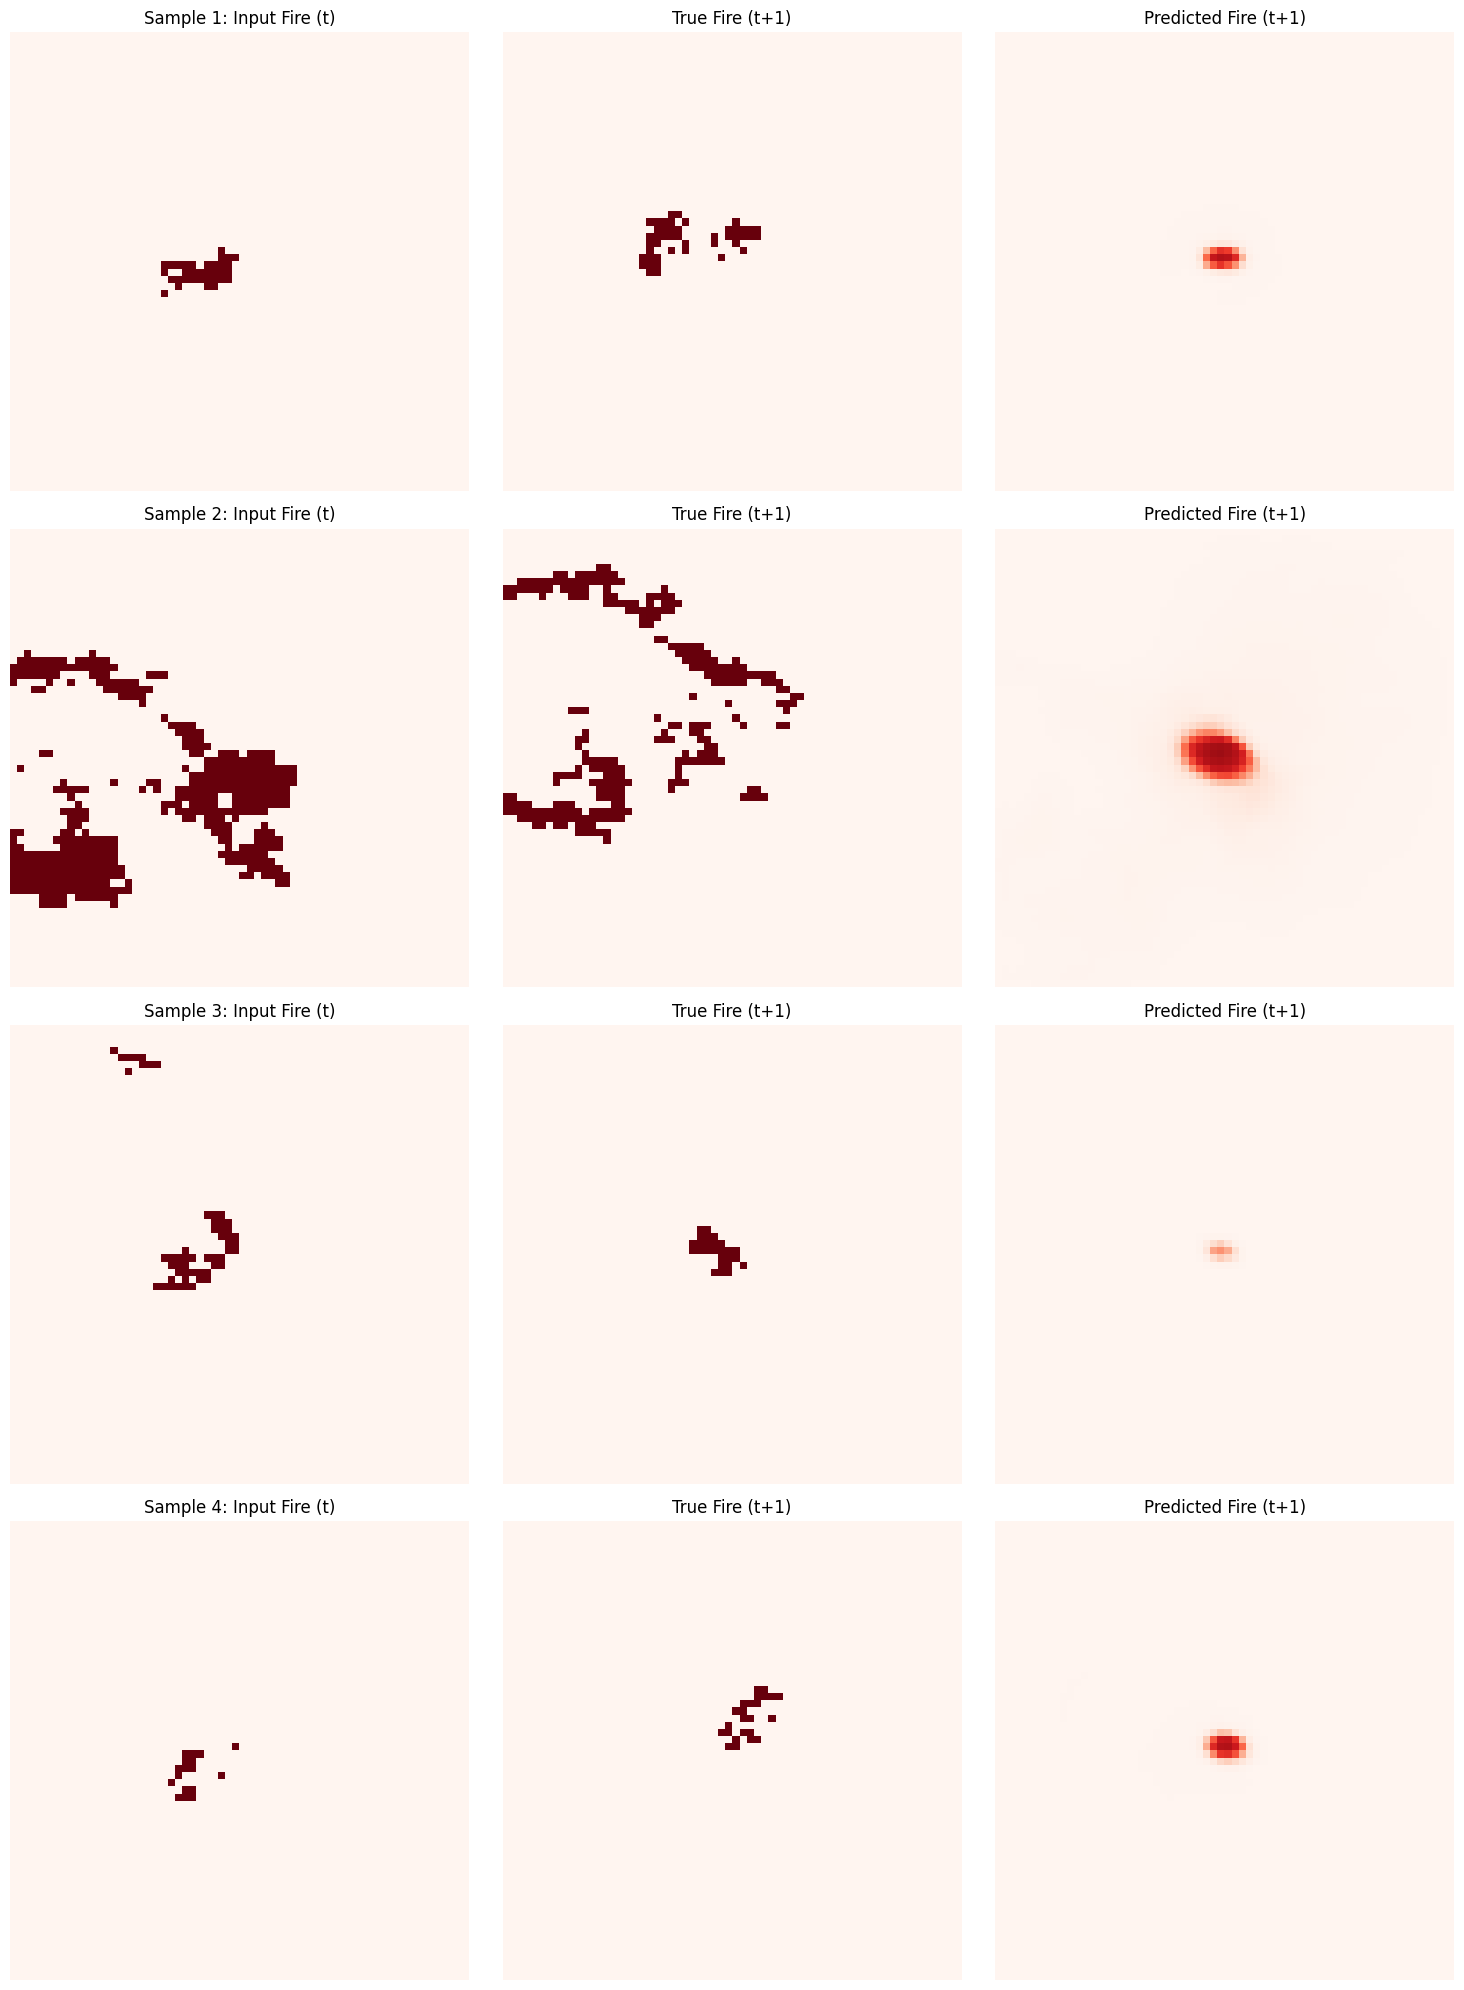


📊 PREDICTION STATISTICS:
🔥 True fire pixels in displayed samples: 361
🎯 Predicted fire pixels (threshold > 0.5): 65
📈 Average prediction confidence: 0.0073


In [6]:

# --- EXECUTION FOR COMBINED TIME-SERIES MODEL WITH UNET++ ---

model_name = "Combined_UNetPlusPlus"
checkpoint_file = "unetplusplus_checkpoint.pth"

# 1. Initialize the Dataset (without loading all data into RAM)
# First, create a temporary dataset to calculate normalization stats
print("--- Step 1: Preparing Dataset ---")
temp_dataset = WildfireDataset(data_dir=DATA_DIR, num_timesteps=4, max_sequences=10000)
normalization_stats = calculate_normalization_stats(temp_dataset, num_samples=2000)

# Now, create the final dataset with the normalization stats included
full_dataset = WildfireDataset(
    data_dir=DATA_DIR, 
    num_timesteps=4, 
    max_sequences=10000, 
    normalization_stats=normalization_stats
)

# 2. Train the U-Net++ model
final_model_combined_pp = None
cv_results_combined_pp = []

if len(full_dataset) > 0:
    print(f"\n--- Step 2: Training {model_name} ---")
    
    final_model_combined_pp, cv_results_combined_pp = train_fire_unet_cv_pytorch(
        full_dataset,
        n_splits=3,
        epochs=25,
        batch_size=4,
        checkpoint_path=checkpoint_file
    )
    
    if cv_results_combined_pp:
        print(f"\n🎉 {model_name} TRAINING COMPLETED!")
    else:
        print(f"❌ {model_name} training failed or was interrupted!")
else:
    print(f"❌ Cannot train model - dataset is empty!")
    
# 3. Visualize the results
if final_model_combined_pp is not None:
    print(f"\n--- Step 3: Generating Visualizations for {model_name} ---")
    
    kfold = KFold(n_splits=3, shuffle=True, random_state=42)
    _, val_indices = list(kfold.split(full_dataset))[-1]
    
    num_viz_samples = min(4, len(val_indices))
    if num_viz_samples > 0:
        # Get samples directly from the dataset for visualization
        viz_inputs, viz_targets = [], []
        for i in range(num_viz_samples):
            # The dataset returns normalized inputs (C, H, W) and binary targets (C, H, W)
            x, y = full_dataset[val_indices[i]]
            viz_inputs.append(np.transpose(x.numpy(), (1, 2, 0))) # Transpose to H, W, C
            viz_targets.append(np.transpose(y.numpy(), (1, 2, 0)))

        X_test_norm = np.array(viz_inputs)
        y_test_binary = np.array(viz_targets)

        visualize_fire_predictions_pytorch(
            final_model_combined_pp, X_test_norm, y_test_binary, num_samples=num_viz_samples
        )
    else:
        print("Not enough validation samples to visualize.")
        
else:
    print(f"\n⚠️ {model_name} model not available for evaluation.")